In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import ngrams

import re
import collections
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer


In [2]:
## Clean tweets dataset
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def clean(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [3]:
pd.set_option('display.max_colwidth', -1)

train = pd.read_csv(open('data/train.csv','rU'), encoding='utf-8', engine='python')
test = pd.read_csv(open('data/test.csv','rU'), encoding='utf-8', engine='python')

train = train.sample(frac=.05001)
test = test.sample(frac=.016666)

train['cleaned_tweet'] = train.SentimentText.apply(clean)
test['cleaned_tweet'] = test.SentimentText.apply(clean)

test_1 = pd.read_csv('data/unclassified_1.csv')
test_2 = pd.read_csv('data/unclassified_1.csv')

#display(train.head(5))

X = train.SentimentText
y = train.Sentiment

X_unclassified = test.cleaned_tweet.values


#print(X.shape)
#print(X_test.shape)

In [4]:
tfidf = TfidfVectorizer()
svc_tfidf = SVC()

svc_tfidf_pipeline = Pipeline([('tfidf', tfidf),('svc', svc_tfidf)])

svc_tfidf_param_grid = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__stop_words' : ['english'],
    'svc__C': [1, 2, 100, 200],
    'svc__kernel': ['linear']
}

## Cross Validate
svc_tfidf_model = GridSearchCV(svc_tfidf_pipeline, svc_tfidf_param_grid)
svc_tfidf_model.fit(X, y)

## Results
print('TF-IDF and SVC Best Options: ', svc_tfidf_model.best_params_)
print('TF-IDF and SVc Model performance: ',round(svc_tfidf_model.best_score_ * 100, 2) ,'%')

Count Vect and SVC Best Options:  {'svc__C': 1, 'svc__kernel': 'linear', 'tfidf__max_df': 0.25, 'tfidf__ngram_range': (1, 3), 'tfidf__stop_words': 'english'}
Count Vect and SVc Model performance:  70.4 %


In [5]:
svc_tfidf_model.best_estimator_

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.25, max_features=None,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('svc',
                 SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr',

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=171995, test_size=0.2)

print(f'TRAIN SHAPES: X = {X_train.shape}, y = {y_train.shape}')
print(f'\nTEST SHAPES: X = {X_test.shape}, y = {y_test.shape}')

feature_extraction = svc_tfidf_model.best_estimator_['tfidf']
X_train = feature_extraction.fit_transform(X_train)

TRAIN SHAPES: X = (4000,), y = (4000,)

TEST SHAPES: X = (1000,), y = (1000,)


In [7]:
new_model = svc_tfidf_model.best_estimator_['svc']
new_model.fit(X_train, y_train)

X_test = feature_extraction.transform(X_test)
print(f'\nTEST SHAPES: X = {X_test.shape}, y = {y_test.shape}')
print(f'Accuracy: {new_model.score(X_test,y_test) * 100}%')


TEST SHAPES: X = (1000, 54632), y = (1000,)
Accuracy: 69.1%


In [8]:
y_predictions = new_model.predict(X_test)

data = {'tweet': [x for x in feature_extraction.inverse_transform(X_test)], 'predictions': [ i for i in y_predictions ] }
df = pd.DataFrame(data=data)
df.head(10)

,tweet,predictions
0,"[party, pre, thankyou, wedding, yes]",1
1,"[alexalltimelow, com, dude, http, http twitpic, http twitpic com, love, love picture, picture, shit, try, twitpic, twitpic com, ve, ve wanted, wanted, wantz, yo]",1
2,"[f1, start]",0
3,"[damn, does, fifth, quot, straight, wins]",1
4,"[eating, editing, shoot, wife, yesterday]",1
5,"[102, day, face, haters, thanks]",1
6,"[family, kate, poor, sigh, team]",0
7,"[ali, guess, know, life, lol, pretty, ve, week]",1
8,"[friday, getting, getting ready, ready, weekend]",0
9,"[discovered, music, nice, night, really, saw]",1


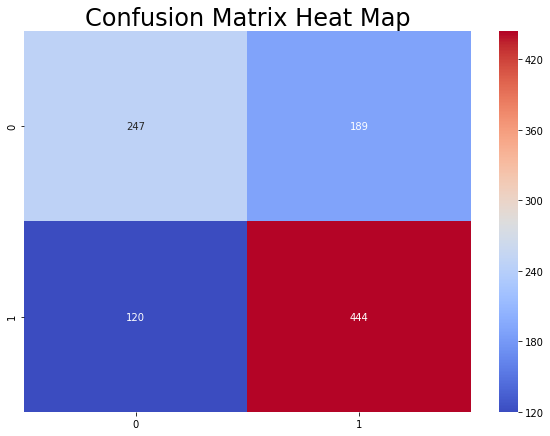

In [9]:
## MODEL EVALUATION

c_matrix = confusion_matrix(y_test, y_predictions)

plt.figure(figsize=(10,7))
plt.title('Confusion Matrix Heat Map',fontsize=24)
sns.heatmap(c_matrix ,cmap='coolwarm',annot=True, fmt='g')

In [10]:
## Exporting Model Artifacts to use them in a Flask API
from sklearn.externals import joblib

joblib.dump(new_model, 'model_artifacts/model.sav')
joblib.dump(feature_extraction, 'model_artifacts/tfidf_vectorizer.sav')

['model_artifacts/tfidf_vectorizer.sav']

In [11]:
x = [
    "terrible app doens't work, wast of time, don't buy",
    "very nice application, would buy",
]


print(new_model.predict(feature_extraction.transform(x)))

[0 1]


In [12]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.22.2.post1.


In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
round(mean_squared_error(y_test, y_predictions, squared=False),4)

0.5559